In [1]:
'''download modules'''
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''importing data'''
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## model inputs
our artificial model input is a random latent space, this latent space will be fed into a generator network to produce a real life image

In [3]:
'''create model inputs
   we create the inputs for our graph using placeholder
   one placeholder for real inputs
   one placeholder for z(generative inputs)
   
   params
   ======
   real_dim, int: tensor/dimension for real inputs
   z_dim, int: tensor/dimension for generated inputs
   
   returns
   =======
   inputs_real, placeholder: placeholder for real inputs in our graphs
   inputs_z, placeholder: placeholder for generated inputs in our graphs
'''
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, shape = (None, real_dim), name = 'inputs_real')
    inputs_z = tf.placeholder(tf.float32, shape = (None, z_dim), name = 'inputs_z')
    
    return inputs_real, inputs_z

## generator network

In [4]:
'''build generator flow, used tf.variable_scope
   
   params
   ======
   z, tensor: input space, 100
   out_dim, tensor: dimension of outputs, 784
   number_units, tensor: hidden nodes
   alpha: alpha
   
   returns
   =======
   out, tensor: a tensor that generated by generator network, this tensor will be examine
      by the discriminative network
   logits, tensor: same dimensions as out 

'''
def generator(z, out_dim, number_units = 128, reuse = False, alpha = 0.01):
    '''now everything under this variable_scope 'generator' is grouped in graph flow'''
    with tf.variable_scope('generator', reuse = reuse):
        #hidden layer
        h1 = tf.layers.dense(z, number_units, activation = None)
        #leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
    
        #logits and tanh output
        logits = tf.layers.dense(h1, out_dim, activation = None)
        out = tf.tanh(logits)
    
        return out

## discriminator network

In [5]:
'''discriminator network is almost same with generator, the difference
   is just that out for discriminator is used sigmoid instead tanh
   x = input of real image and also sometimes also inputted from generator
'''
def discriminator(x, number_units = 128, reuse = False, alpha = 0.01):
    '''now everything under this variable scope 'discriminator' is grouped in graph flow '''
    with tf.variable_scope('discriminator', reuse = reuse):
        #hidden layer
        h1 = tf.layers.dense(x, number_units, activation = None)
        #leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation = None)
        out = tf.sigmoid(logits)
        
        return out, logits

## hyperparameters

In [6]:
#size of input image to discriminator
input_size = 784
#size of latent vector to generator (z input)
z_size = 100

#size of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128

#leak factor for leaky ReLU
alpha = 0.01

#smoothing
smooth = 0.1

## build network
now we are build the network from the functions defined above

first is to get our inputs, input_real, input_z from model_inputs using the sizes of the input and z

then we will create the generator, generator(input_z, input_size), this builds the generator with appropriate input and output sizes

then the discriminator, WE WILL BUILD 2 OF THEM, ONE FOR REAL DATA AND ONE FOR FAKE DATA, since we want to use the exact same graph and weights for both we want to reuse the variable. For the fake data we get from generator as g_model so the real discriminator is discriminator(input_real) while the fake discriminator(g_model, reuse = True)

In [7]:
tf.reset_default_graph()
'''create our input placeholders using model_inputs function'''
input_real, input_z = model_inputs(input_size, z_size)

'''build the model for generator output
   input size comes from the original size of flatten image, see hyperparameters
   generator model is the genertor output
'''
generator_model = generator(input_z, input_size, number_units = g_hidden_size, alpha = alpha)

'''discriminator model
   for discriminator model for fake data we inputted the generator_model function above
'''
discriminator_real, discriminator_logits_real = discriminator(input_real, number_units = d_hidden_size, alpha = alpha)
discriminator_fake, discriminator_logits_fake = discriminator(generator_model, reuse = True, number_units = d_hidden_size, 
                                                             alpha = alpha)

## discriminator and generator losses
the losses will be sigmoid cross-entropy

discriminator_loss = discriminator_loss_real + discriminator_loss_fake

In [8]:
'''calculate losses that will be used while training'''
discriminator_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( 
                                         labels= tf.ones_like(discriminator_logits_real) * (1 - smooth),
                                         logits = discriminator_logits_real))

discriminator_loss_fake = tf.reduce_mean(
                            tf.nn.sigmoid_cross_entropy_with_logits( 
                            labels = tf.zeros_like(discriminator_logits_real),
                            logits = discriminator_logits_fake))

discriminator_loss = discriminator_loss_real + discriminator_loss_fake

generator_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits( 
                    labels = tf.ones_like(discriminator_logits_fake),
                    logits = discriminator_logits_fake))

## optimizer

we use tf.trainable_variables() and use different variables that we already grouped with tf.variable_scope

In [9]:
learning_rate = 0.002

'''get the trainable_variables, split into generator and discriminator parts'''
trainable_variables = tf.trainable_variables()
generator_variables = [variable for variable in trainable_variables if variable.name.startswith('generator')]
discriminator_variables = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]

discriminator_train_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(discriminator_loss,
                                                                               var_list = discriminator_variables)

generator_train_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(generator_loss, 
                                                                          var_list = generator_variables)


## training

In [10]:
batch_size = 100
epochs = 100
samples = []
losses = []
'''only save generator variables'''
saver = tf.train.Saver(var_list = generator_variables)

with tf.Session() as sess:
    '''run global initializer'''
    sess.run(tf.global_variables_initializer())
    '''writer for tensorboard'''
    writer = tf.summary.FileWriter('graphs/mnist_gan', sess.graph)
    
    '''loop for each epochs'''
    for epoch in range(epochs):
        for number_batch in range(mnist.train.num_examples // batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            '''get images, reshape and rescale to pass to discriminator'''
            batch_images = batch[0].reshape((batch_size, 784)) #784 is the size of input_size
            batch_images = batch_images * 2 - 1
            
            '''sample RANDOM NOISE FOR GENERATOR'''
            batch_z = np.random.uniform(-1, 1, size = (batch_size, z_size)) #z_size is 100
            
            '''run optimizers'''
            _ = sess.run(discriminator_train_optimizer, feed_dict = {input_real: batch_images, input_z: batch_z})
            _ = sess.run(generator_train_optimizer, feed_dict = {input_z: batch_z})
            
        '''at the end of each epochs, get loss function'''
        train_loss_discriminator = sess.run(discriminator_loss, feed_dict = {input_z: batch_z, input_real: batch_images})
        train_loss_generator = sess.run(generator_loss, feed_dict = {input_z: batch_z})
        
        print("epoch: {}/{} discriminator_loss: {} generator_loss: {}"
              .format(epoch, epochs, train_loss_discriminator, train_loss_generator))
        
        '''saves losses to plot after'''
        losses.append((train_loss_discriminator, train_loss_generator))
        
        '''sample from generator as we are training for viewing afterwards
           here we use our trained generator network to produce the new image
           from a random latent sample z
           reuse = True to use again trained generator
        '''
        sample_z = np.random.uniform(-1, 1, size = (16, z_size))
        generated_samples = sess.run(generator(input_z, input_size, number_units = g_hidden_size, 
                                             reuse = True, alpha = alpha), feed_dict = {input_z: sample_z})
        samples.append(generated_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
    
    '''close writer'''
    writer.close()
    
'''save training generator samples'''
with open('train_samples.pkl', 'wb') as file:
    pkl.dump(samples, file)

epoch: 0/100 discriminator_loss: 0.3908527195453644 generator_loss: 3.370723247528076
epoch: 1/100 discriminator_loss: 0.3718140125274658 generator_loss: 4.401033401489258
epoch: 2/100 discriminator_loss: 0.911127507686615 generator_loss: 4.132309436798096
epoch: 3/100 discriminator_loss: 1.2544506788253784 generator_loss: 3.016974449157715
epoch: 4/100 discriminator_loss: 1.5734667778015137 generator_loss: 2.2269906997680664
epoch: 5/100 discriminator_loss: 1.040248990058899 generator_loss: 3.3313355445861816
epoch: 6/100 discriminator_loss: 0.6492667198181152 generator_loss: 2.6952669620513916
epoch: 7/100 discriminator_loss: 1.274784803390503 generator_loss: 1.6214593648910522
epoch: 8/100 discriminator_loss: 0.8641308546066284 generator_loss: 2.6158864498138428
epoch: 9/100 discriminator_loss: 1.1534655094146729 generator_loss: 1.3031588792800903
epoch: 10/100 discriminator_loss: 0.8392695188522339 generator_loss: 3.0934505462646484
epoch: 11/100 discriminator_loss: 0.9381737709045

## training loss

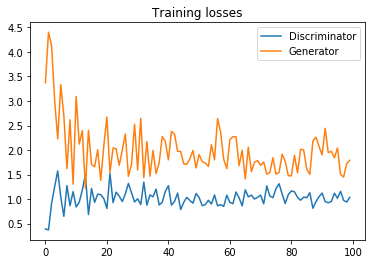

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label = 'Discriminator')
plt.plot(losses.T[1], label = 'Generator')
plt.title('Training losses')
plt.legend()

## generate samples from training

In [12]:
with open('train_samples.pkl', 'rb') as file:
    samples = pkl.load(file)

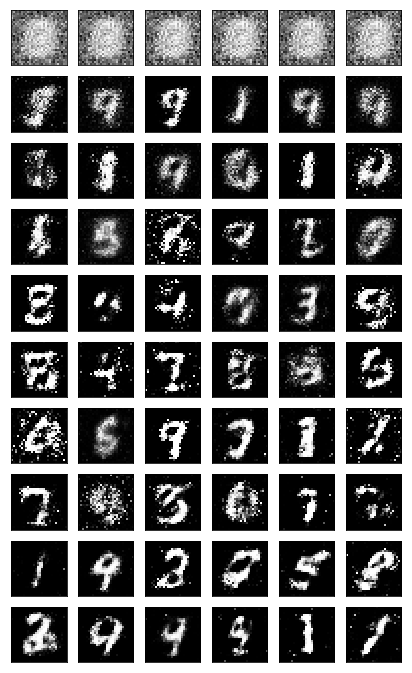

In [17]:
rows = 10
cols = 6

fig, axes = plt.subplots(figsize = (7, 12), nrows = rows, ncols = cols, sharex = True, sharey = True)
for sample, ax_row, in zip(samples[ : : int(len(samples) / rows)], axes):
    for img, ax in zip(sample[ : : int(len(sample) / cols)], ax_row):
        ax.imshow(img.reshape((28, 28)), cmap = 'Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [18]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize = (7, 7), nrows = 4, ncols = 4, sharey = True, sharex = True)
    
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28, 28)), cmap = 'Greys_r')
        
    return fig, axes

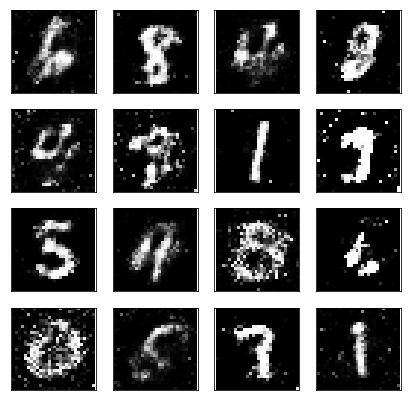

In [19]:
_ = view_samples(-1, samples) #-1 is the last epoch, since we assume that last trained is the optimal model